Importing all the libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Importing the dataset

In [ ]:
df = pd.read_csv('ncr_ride_bookings.csv')
print("Successfully loaded ncr_ride_bookings.csv")
print(f"Original shape: {df.shape}")

Successfully loaded ncr_ride_bookings.csv
Original shape: (150000, 21)


In [ ]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,NaN,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,NaN,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,NaN,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,NaN,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


Various Reasons For Why A Cancellation May Happen

In [ ]:
df1 = df.copy()
df1['Reason for cancelling by Customer'].value_counts()

,count
Reason for cancelling by Customer,
Wrong Address,2362
Change of plans,2353
Driver is not moving towards pickup location,2335
Driver asked to cancel,2295
AC is not working,1155


In [ ]:
df1['Driver Cancellation Reason'].value_counts()

,count
Driver Cancellation Reason,
Customer related issue,6837
The customer was coughing/sick,6751
Personal & Car related issues,6726
More than permitted people in there,6686


Creating Timestamp For When Booking Occurs

Also Creating two is_cancelled filters, one when the cancellation reason is due to driver not moving. Another when cancellation is done by either Customer or Driver for any reason whatsoever

In [ ]:
# --- Data Cleaning ---
# Combine Date and Time into a single datetime object
df1['booking_timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
dt_series = pd.to_datetime(df1['booking_timestamp'], errors='coerce')

# Extract useful time-based features
df1['hour'] = dt_series.dt.hour
df1['day'] = dt_series.dt.day_name()
df1['month'] = dt_series.dt.month
df1['day_of_month'] = dt_series.dt.day

drop_columns = ['Date', 'Time']
df1 = df1.drop(drop_columns, axis=1)

# Create the target variable 'is_cancelled'
# We define a cancellation as any ride where either the customer or driver cancelled.
df1['is_cancelled_a'] = ((df1['Cancelled Rides by Customer'] == 1) | (df1['Cancelled Rides by Driver'] == 1)).astype(int)
df1['is_cancelled'] = (df1['Reason for cancelling by Customer'] == "Driver is not moving towards pickup location").astype(int)
# Display the first few rows with the new columns
print(df1[['month','day_of_month','day','hour','is_cancelled']].head())

   month  day_of_month       day  hour  is_cancelled
0      3            23  Saturday    12             0
1     11            29    Friday    18             0
2      8            23    Friday     8             0
3     10            21    Monday    17             0
4      9            16    Monday    22             0


Using The Filters To Plot Distribution for EDA

/tmp/ipython-input-1594381580.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Reason for cancelling by Customer', data=df1, palette="viridis")


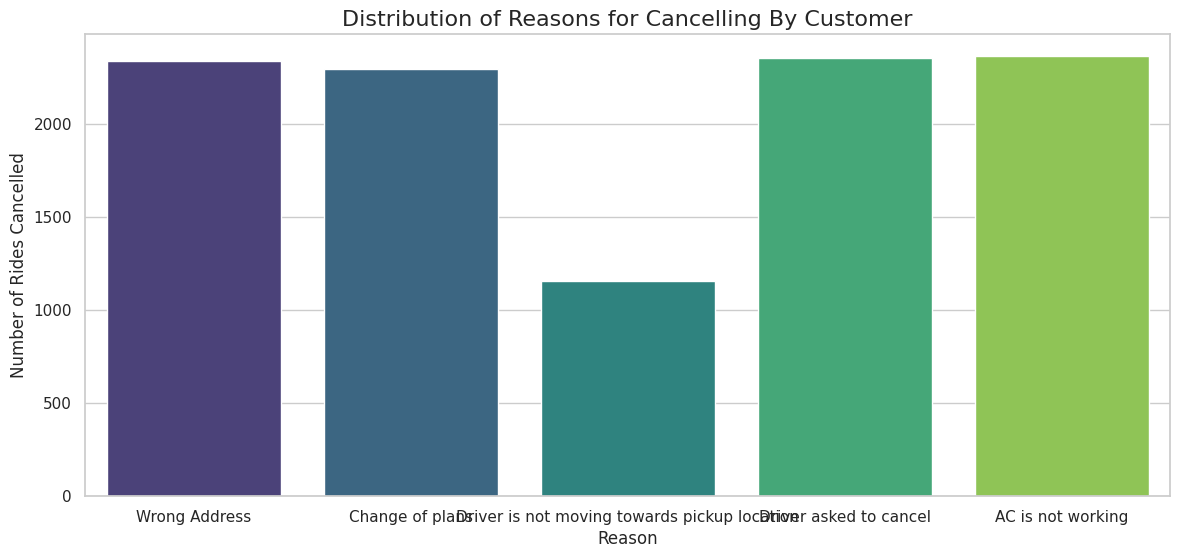

Reason for cancelling by Customer
Wrong Address                                   0.224952
Change of plans                                 0.224095
Driver is not moving towards pickup location    0.222381
Driver asked to cancel                          0.218571
AC is not working                               0.110000
Name: proportion, dtype: float64


In [ ]:
# Checking imbalance
# Set the plot style
sns.set_style("whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(14, 6))
sns.countplot(x='Reason for cancelling by Customer', data=df1, palette="viridis")
plt.title('Distribution of Reasons for Cancelling By Customer', fontsize=16)
plt.xticks([0, 1, 2, 3, 4], ['Wrong Address', 'Change of plans', 'Driver is not moving towards pickup location', 'Driver asked to cancel', 'AC is not working'])

plt.ylabel('Number of Rides Cancelled')
plt.xlabel('Reason')
plt.show()

print(df1['Reason for cancelling by Customer'].value_counts(normalize=True))

/tmp/ipython-input-3553415748.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Driver Cancellation Reason', data=df1, palette="viridis")


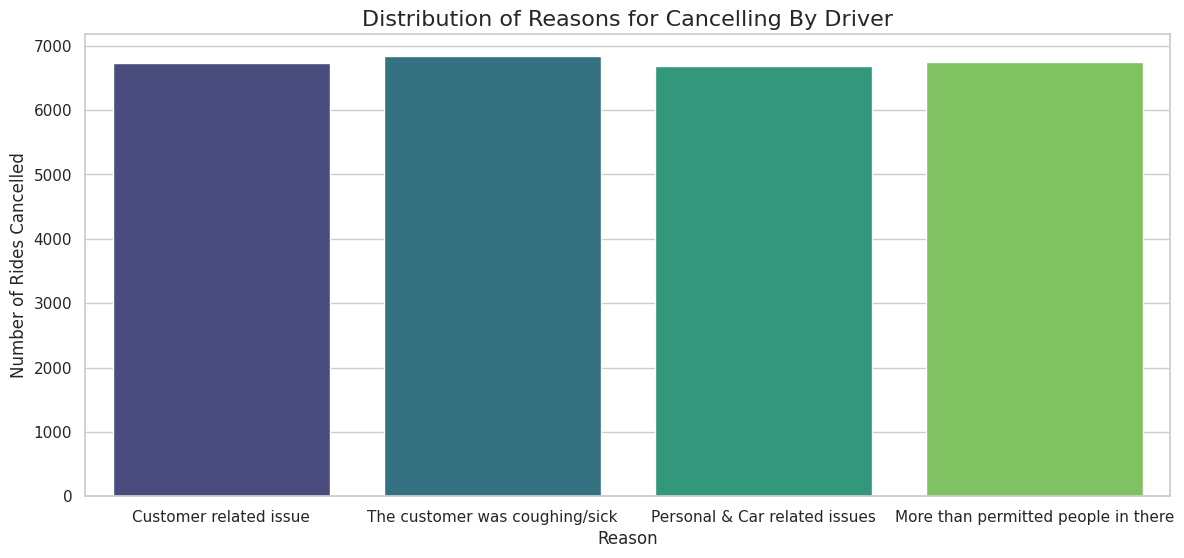

Reason for cancelling by Customer
Wrong Address                                   0.224952
Change of plans                                 0.224095
Driver is not moving towards pickup location    0.222381
Driver asked to cancel                          0.218571
AC is not working                               0.110000
Name: proportion, dtype: float64


In [ ]:
# Checking imbalance
# Set the plot style
sns.set_style("whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(14, 6))
sns.countplot(x='Driver Cancellation Reason', data=df1, palette="viridis")
plt.title('Distribution of Reasons for Cancelling By Driver', fontsize=16)
plt.xticks([0, 1, 2, 3], ['Customer related issue', 'The customer was coughing/sick', 'Personal & Car related issues', 'More than permitted people in there'])

plt.ylabel('Number of Rides Cancelled')
plt.xlabel('Reason')
plt.show()

print(df1['Reason for cancelling by Customer'].value_counts(normalize=True))

/tmp/ipython-input-3613315337.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_cancelled', data=df1, palette="viridis")


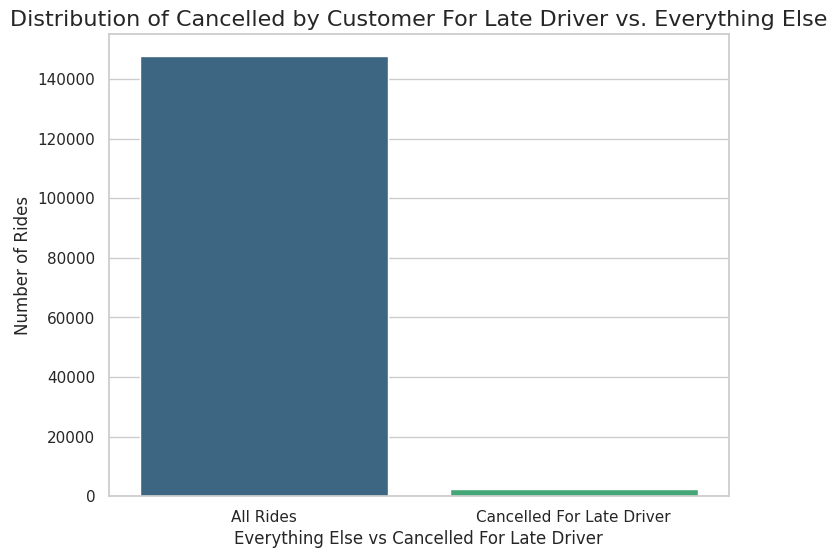

is_cancelled
0    0.984433
1    0.015567
Name: proportion, dtype: float64


<Figure size 800x600 with 0 Axes>

In [ ]:
# Checking imbalance
# Set the plot style
sns.set_style("whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='is_cancelled', data=df1, palette="viridis")
plt.title('Distribution of Cancelled by Customer For Late Driver vs. Everything Else', fontsize=16)
plt.xticks([0, 1], ['All Rides', 'Cancelled For Late Driver'])
plt.ylabel('Number of Rides')
plt.xlabel('Everything Else vs Cancelled For Late Driver')
plt.show()


plt.figure(figsize=(8, 6)) # Set a good figure size
sns.set_theme(style="whitegrid") # Apply a nice theme

print(df1['is_cancelled'].value_counts(normalize=True))

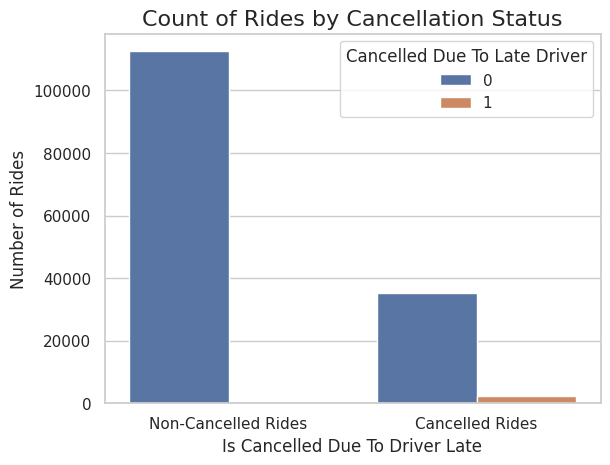

is_cancelled_a
0    0.75
1    0.25
Name: proportion, dtype: float64


In [ ]:

ax = sns.countplot(
    data=df1,
    x='is_cancelled_a',
    hue='is_cancelled'
)

# 3. Add titles and labels for clarity
ax.set_title('Count of Rides by Cancellation Status', fontsize=16)
ax.set_xlabel('Is Cancelled Due To Driver Late', fontsize=12)
ax.set_ylabel('Number of Rides', fontsize=12)
plt.xticks([0, 1], ['Non-Cancelled Rides', 'Cancelled Rides'])
ax.legend(title='Cancelled Due To Late Driver') # Update legend title

# 4. Show the plot
# In a typical Python environment, this will open a new window
# with your plot.
plt.show()

print(df1['is_cancelled_a'].value_counts(normalize=True))

Dropping all rows where Booking Status Isn't "Complete" or "Cancelled by Customer"

In [ ]:
statuses_to_drop = ['Incomplete', 'No Driver Found', 'Cancelled by Driver']

original_row_count = len(df1)
# We use .isin() to find rows with these statuses and '~' (NOT) to keep all other rows
df1 = df1[~df1['Booking Status'].isin(statuses_to_drop)]
dropped_row_count = original_row_count - len(df1)
print(f"Dropped {dropped_row_count} rows with statuses: {', '.join(statuses_to_drop)}")

Dropped 46500 rows with statuses: Incomplete, No Driver Found, Cancelled by Driver


In [ ]:
df1['Driver Cancellation Reason'].value_counts()

,count
Driver Cancellation Reason,


Dropping All Rows where Cancellation Reason isn't "Driver isn't moving"

In [ ]:
statuses_to_drop = ['Wrong Address', 'Change of plans', 'Driver asked to cancel', 'AC is not working']
original_row_count = len(df1)
# We use .isin() to find rows with these statuses and '~' (NOT) to keep all other rows
df1 = df1[~df1['Reason for cancelling by Customer'].isin(statuses_to_drop)]
dropped_row_count = original_row_count - len(df1)
print(f"Dropped {dropped_row_count} rows with statuses: {', '.join(statuses_to_drop)}")

Dropped 8165 rows with statuses: Wrong Address, Change of plans, Driver asked to cancel, AC is not working


In [ ]:
df1['Reason for cancelling by Customer'].value_counts()

,count
Reason for cancelling by Customer,
Driver is not moving towards pickup location,2335


In [ ]:
print(df1.shape)

(95335, 26)


Calculating Average Distance between Same Pickup Location and Drop Location for Imputation

In [ ]:
# 2. Calculate the mean 'Ride Distance' for each 'Pickup Location' and 'Drop Location' group.
# .transform('mean') calculates the mean for each group and then broadcasts
# that value back to every row belonging to that group.
# It automatically handles NaNs in the calculation (ignores them).
group_avg_distance = df1.groupby(['Pickup Location', 'Drop Location'])['Ride Distance'].transform('mean')

# Let's print this intermediate series to see what it looks like
print("--- Calculated Ride Distance Group Averages (to be used for imputation) ---")
print(group_avg_distance)

# 3. Define the condition for imputation
# We only want to fill rows where:
#    a) 'Ride Distance' is missing (isnull())
#    AND
#    b) 'is_cancelled' is True
condition_to_impute = (df1['Ride Distance'].isnull()) & (df1['is_cancelled'] == True)

# 4. Apply the imputation using .loc
# We select the rows based on our condition and the 'Ride Distance' column.
# Then, we set those specific cells equal to the corresponding
# value from our 'group_avg_distance' series.
df1.loc[condition_to_impute, 'Ride Distance'] = group_avg_distance[condition_to_impute]

Streaming output truncated to the last 5000 lines.
142017    19.722500
142019    27.032857
142020     7.320000
142021    25.642500
142023     7.510000
142024     6.076667
142025    25.144000
142027    24.341000
142028    26.606667
142030    20.745000
142031    25.270000
142033    36.805000
142034    38.146667
142035    46.255000
142036    25.853333
142038    27.202000
142039    30.886667
142043    21.095000
142044    49.280000
142047    32.093333
142048    19.645000
142050    11.535000
142053    21.380000
142054    28.352000
142055    19.513333
142056    18.730000
142057    29.104000
142059    26.688333
142061    10.813333
142063    20.698000
142066    35.996667
142067    32.890000
142068    18.492500
142069    34.006667
142074    21.695000
142075    26.437500
142076    34.440000
142077    26.915000
142078    33.540000
142079    33.500000
142080    21.412500
142081    14.481667
142083    31.745000
142084    32.533333
142085    26.696667
142087    32.540000
142088    22.115000
142089   

Doing the same but this time to impute Cost

In [ ]:
# 2. Calculate the mean 'Ride Distance' for each 'Pickup Location' and 'Drop Location' group.
# .transform('mean') calculates the mean for each group and then broadcasts
# that value back to every row belonging to that group.
# It automatically handles NaNs in the calculation (ignores them).
group_avg_cost = df1.groupby(['Pickup Location', 'Drop Location'])['Booking Value'].transform('mean')

# Let's print this intermediate series to see what it looks like
print("--- Calculated Booking Value Group Averages (to be used for imputation) ---")
print(group_avg_cost)

# 3. Define the condition for imputation
# We only want to fill rows where:
#    a) 'Ride Distance' is missing (isnull())
#    AND
#    b) 'is_cancelled' is True
condition_to_impute = (df1['Booking Value'].isnull()) & (df1['is_cancelled'] == True)

# 4. Apply the imputation using .loc
# We select the rows based on our condition and the 'Ride Distance' column.
# Then, we set those specific cells equal to the corresponding
# value from our 'group_avg_distance' series.
df1.loc[condition_to_impute, 'Booking Value'] = group_avg_cost[condition_to_impute]

Streaming output truncated to the last 5000 lines.
142017     394.000000
142019     380.857143
142020     708.500000
142021     956.750000
142023     610.000000
142024     657.333333
142025     617.600000
142027     539.400000
142028     356.666667
142030     366.000000
142031     239.666667
142033     378.833333
142034     767.666667
142035     330.000000
142036     354.333333
142038     781.200000
142039     530.333333
142043     323.000000
142044     447.000000
142047     604.333333
142048     590.750000
142050     696.500000
142053     573.666667
142054     504.600000
142055     414.000000
142056     390.000000
142057     819.600000
142059     494.833333
142061     720.333333
142063     593.200000
142066     353.666667
142067     553.000000
142068     697.750000
142069     472.000000
142074     433.000000
142075     413.750000
142076     269.750000
142077     477.500000
142078     647.333333
142079     347.200000
142080     327.000000
142081     458.166667
142083     403.500000
142

Using the filter to select specific Pickup and Drop Locations to check if Imputation was Successful

In [ ]:
# Apply the filter for both Pickup and Drop locations
# We use the '&' (AND) operator to combine the two conditions.
filtered_df = df1[
    (df1['Pickup Location'] == "Kashmere Gate") &
    (df1['Drop Location'] == "Anand Vihar")
]

# 3. Print the filtered DataFrame
print("Filtered DataFrame")
print(filtered_df.shape)
filtered_df.head()

Filtered DataFrame
(2, 26)


,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,booking_timestamp,hour,day,month,day_of_month,is_cancelled_a,is_cancelled
18,"""CNR6126048""",Cancelled by Customer,"""CID1060329""",eBike,Kashmere Gate,Anand Vihar,12.4,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,435.0,41.25,NaN,NaN,NaN,2024-11-24 09:07:10,9,Sunday,11,24,1,1
19032,"""CNR7405728""",Completed,"""CID2234168""",Go Sedan,Kashmere Gate,Anand Vihar,6.9,44.8,NaN,NaN,NaN,NaN,NaN,NaN,435.0,41.25,4.8,4.9,Credit Card,2024-03-20 11:50:21,11,Wednesday,3,20,0,0


Imputation was definitely Successful

In [ ]:
# 5. Print the final, imputed DataFrame
print("--- Imputed DataFrame ---")
df1[df1["Booking Status"] == "Cancelled by Customer"].head(10)

--- Imputed DataFrame ---


,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,booking_timestamp,hour,day,month,day_of_month,is_cancelled_a,is_cancelled
18,"""CNR6126048""",Cancelled by Customer,"""CID1060329""",eBike,Kashmere Gate,Anand Vihar,12.4,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,435.000000,41.250000,NaN,NaN,NaN,2024-11-24 09:07:10,9,Sunday,11,24,1,1
39,"""CNR4218487""",Cancelled by Customer,"""CID3037053""",Bike,Noida Extension,Udyog Vihar Phase 4,11.0,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,642.166667,19.938333,NaN,NaN,NaN,2024-09-10 13:02:42,13,Tuesday,9,10,1,1
62,"""CNR2497989""",Cancelled by Customer,"""CID5007066""",Auto,Karkarduma,IGI Airport,16.6,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,492.333333,25.060000,NaN,NaN,NaN,2024-02-09 11:15:59,11,Friday,2,9,1,1
214,"""CNR9619867""",Cancelled by Customer,"""CID9032039""",Go Sedan,Civil Lines Gurgaon,Moti Nagar,10.2,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,940.400000,27.592000,NaN,NaN,NaN,2024-03-04 21:24:16,21,Monday,3,4,1,1
537,"""CNR3404014""",Cancelled by Customer,"""CID5570791""",Auto,Sarai Kale Khan,Raj Nagar Extension,7.6,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,790.333333,29.803333,NaN,NaN,NaN,2024-10-20 20:40:00,20,Sunday,10,20,1,1
593,"""CNR8163591""",Cancelled by Customer,"""CID2960805""",Go Sedan,Lok Kalyan Marg,New Colony,9.1,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,567.500000,19.000000,NaN,NaN,NaN,2024-07-21 18:19:54,18,Sunday,7,21,1,1
680,"""CNR7634326""",Cancelled by Customer,"""CID9472411""",Bike,Mehrauli,AIIMS,9.9,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,457.666667,27.140000,NaN,NaN,NaN,2024-12-05 18:34:10,18,Thursday,12,5,1,1
715,"""CNR8967861""",Cancelled by Customer,"""CID3540282""",Premier Sedan,Sohna Road,Nehru Place,10.6,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,613.800000,36.118000,NaN,NaN,NaN,2024-09-14 15:45:33,15,Saturday,9,14,1,1
757,"""CNR1334676""",Cancelled by Customer,"""CID6137231""",Bike,Govindpuri,Uttam Nagar,10.0,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,781.000000,13.285000,NaN,NaN,NaN,2024-03-18 10:56:23,10,Monday,3,18,1,1
770,"""CNR1402875""",Cancelled by Customer,"""CID6416624""",Auto,IMT Manesar,Narsinghpur,7.0,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,486.333333,25.103333,NaN,NaN,NaN,2024-01-19 20:47:33,20,Friday,1,19,1,1


Despite Imputing Distance From Other Examples In The Dataset, there are still some Null rows

In [ ]:
print("Imputed DataFrame With Ride Distance Missing")
print(df1[df1["Ride Distance"].isnull()].shape)
df1[df1["Ride Distance"].isnull()].head()

Imputed DataFrame With Ride Distance Missing
(100, 26)


,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,booking_timestamp,hour,day,month,day_of_month,is_cancelled_a,is_cancelled
1837,"""CNR8564653""",Cancelled by Customer,"""CID2008601""",Go Mini,AIIMS,Kadarpur,13.8,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-01-09 22:25:39,22,Tuesday,1,9,1,1
3396,"""CNR8695203""",Cancelled by Customer,"""CID1299296""",Premier Sedan,Dwarka Sector 21,Paharganj,18.1,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-03-05 14:33:02,14,Tuesday,3,5,1,1
4498,"""CNR9639880""",Cancelled by Customer,"""CID8435914""",Go Sedan,Golf Course Road,Panipat,14.2,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-27 10:40:50,10,Friday,12,27,1,1
7121,"""CNR7147488""",Cancelled by Customer,"""CID2410401""",Go Mini,Dwarka Mor,Bahadurgarh,10.0,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-09-21 14:59:08,14,Saturday,9,21,1,1
8536,"""CNR3508381""",Cancelled by Customer,"""CID5210121""",Go Mini,Arjangarh,Rohini East,5.1,NaN,1.0,Driver is not moving towards pickup location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-02-17 06:33:02,6,Saturday,2,17,1,1


In [ ]:
original_row_count = len(df1)
# Use .dropna() and specify which column(s) to check for NaN values
df1 = df1.dropna(subset=['Ride Distance'])
dropped_row_count = original_row_count - len(df1)
print(f"Dropped {dropped_row_count} rows where Ride Distance was NaN.")

Dropped 100 rows where Ride Distance was NaN.


In [ ]:
# 1. Sort the DataFrame by Date_Time (CRITICAL STEP)
# This ensures the fill goes from past rides to future rides.
df1 = df1.sort_values(by='booking_timestamp')

# 2. Group by Customer ID, select Customer Rating, and forward fill
# This will fill NaN values with the last valid rating *from that same customer*.
df1['Customer Rating'] = df1.groupby('Customer ID')['Customer Rating'].ffill()

In [ ]:
nan_count = df1['Customer Rating'].isnull().sum()
print(f"Number of NaN values in 'Customer Rating': {nan_count}")

Number of NaN values in 'Customer Rating': 2221


In [ ]:
df1.head()

,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,booking_timestamp,hour,day,month,day_of_month,is_cancelled_a,is_cancelled
122017,"""CNR4352144""",Completed,"""CID8362794""",Bike,Udyog Vihar,Ambience Mall,10.8,38.9,NaN,NaN,NaN,NaN,NaN,NaN,99.0,37.98,4.8,4.8,Cash,2024-01-01 00:19:34,0,Monday,1,1,0,0
79457,"""CNR9147645""",Completed,"""CID8300238""",Go Mini,Basai Dhankot,Madipur,8.5,15.1,NaN,NaN,NaN,NaN,NaN,NaN,114.0,39.29,4.2,4.1,Uber Wallet,2024-01-01 01:35:18,1,Monday,1,1,0,0
118744,"""CNR8140858""",Completed,"""CID9268400""",Go Mini,Jhilmil,Welcome,8.1,42.6,NaN,NaN,NaN,NaN,NaN,NaN,735.0,39.39,4.3,4.7,UPI,2024-01-01 01:53:01,1,Monday,1,1,0,0
126107,"""CNR6073090""",Completed,"""CID7393428""",Go Mini,Sarojini Nagar,Madipur,2.9,33.8,NaN,NaN,NaN,NaN,NaN,NaN,918.0,44.21,3.6,4.9,Cash,2024-01-01 03:59:29,3,Monday,1,1,0,0
142659,"""CNR4082656""",Completed,"""CID9685431""",eBike,Panchsheel Park,Pragati Maidan,8.6,24.3,NaN,NaN,NaN,NaN,NaN,NaN,423.0,40.82,4.4,3.9,Cash,2024-01-01 04:00:07,4,Monday,1,1,0,0


In [ ]:
drop_columns = ['Booking ID', 'Cancelled Rides by Customer','Reason for cancelling by Customer', 'Driver Cancellation Reason','Incomplete Rides', 'Incomplete Rides Reason','Payment Method','is_cancelled_a']
df1 = df1.drop(drop_columns, axis=1)

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Define your bins and labels ---
# We'll group (0, 1, 2) as 'Poor', (3) as 'Average', and (4, 5) as 'Good'
#
# pd.cut() needs bin *edges*.
# So, for integers [0, 1, 2, 3, 4, 5]:
#   - Bin 1: -1 to 2 (includes 0, 1, 2)
#   - Bin 2: 2 to 3  (includes 3)
#   - Bin 3: 3 to 5  (includes 4, 5)
bins = [-1, 2, 3, 5]
labels = ['Poor', 'Average', 'Good']


# --- 2. Apply pd.cut() to create the new columns ---
# This will create the new columns but will produce 'NaN'
# wherever the original rating was 'NaN'.
df1['driver_ratings'] = pd.cut(df1['Driver Ratings'], bins=bins, labels=labels, right=True)
df1['customer_ratings'] = pd.cut(df1['Customer Rating'], bins=bins, labels=labels, right=True)


# --- 3. Handle the 'Not Rated' (NaN) values ---
# This is a critical two-step process for categorical columns:

# 3a. Add 'Not Rated' as a valid category to the column
df1['driver_ratings'] = df1['driver_ratings'].cat.add_categories('Not Rated')
df1['customer_ratings'] = df1['customer_ratings'].cat.add_categories('Not Rated')

# 3b. Now you can fill the NaNs with your new 'Not Rated' category
df1['driver_ratings'] = df1['driver_ratings'].fillna('Not Rated')
df1['customer_ratings'] = df1['customer_ratings'].fillna('Not Rated')

# --- Check your work ---
# print(df1[['Driver_Rating', 'Driver_Rating_Category']].head(10))
# print(df1['Driver_Rating_Category'].value_counts())

In [ ]:
df1['driver_ratings'].value_counts()

,count
driver_ratings,
Good,92255
Not Rated,2235
Average,745
Poor,0


In [ ]:
df1['customer_ratings'].value_counts()

,count
customer_ratings,
Good,92546
Not Rated,2221
Average,468
Poor,0


In [ ]:
# Sorts by 'Avg VTAT' value from smallest to largest
df1[df1['Booking Status'] == "Cancelled by Customer"]['Avg VTAT'].value_counts().sort_index(ascending=True)

,count
Avg VTAT,
5.0,12
5.1,19
5.2,13
5.3,15
5.4,11
5.5,10
5.6,21
5.7,11
5.8,11


In [ ]:
# --- FIX: Clean the 'Customer ID' column ---
# This removes any leading/trailing spaces AND the (") character
print("Original Customer ID:", df1['Customer ID'].iloc[0])
df1['Customer ID'] = df1['Customer ID'].str.strip().str.strip('"')
print("Cleaned Customer ID:", df1['Customer ID'].iloc[0])

Original Customer ID: "CID8362794"
Cleaned Customer ID: CID8362794


In [ ]:
# --- 2. Sort by Customer and Time ---
# This ensures our historical calculations are correct.
df1 = df1.sort_values(by=['Customer ID', 'booking_timestamp'])

# --- 3. Isolate 'Avg VTAT' for Cancelled Rides ---
# Create a temporary column that only has a value if the ride was cancelled.
df1['vtat_if_cancelled'] = df1['Avg VTAT'].where(df1['is_cancelled'] == 1)

print("--- 2. DataFrame with 'vtat_if_cancelled' ---")
df1.head()


--- 2. DataFrame with 'vtat_if_cancelled' ---


,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,booking_timestamp,hour,day,month,day_of_month,is_cancelled,driver_ratings,customer_ratings,vtat_if_cancelled
148537,Completed,CID1000234,Go Sedan,Mandi House,Ghitorni,6.2,31.6,NaN,458.0,13.32,4.2,4.3,2024-09-26 12:58:18,12,Thursday,9,26,0,Good,Good,NaN
43914,Completed,CID1000323,Bike,Delhi Gate,Ashram,13.9,15.5,NaN,1498.0,20.26,4.3,4.5,2024-03-22 10:10:36,10,Friday,3,22,0,Good,Good,NaN
147050,Completed,CID1000448,Auto,IMT Manesar,Arjangarh,2.0,21.9,NaN,448.0,12.93,3.1,4.2,2024-03-02 11:44:26,11,Saturday,3,2,0,Good,Good,NaN
133855,Completed,CID1000469,eBike,Mundka,Vaishali,6.2,26.8,NaN,419.0,36.14,4.3,4.3,2024-02-11 10:14:40,10,Sunday,2,11,0,Good,Good,NaN
52478,Completed,CID1000588,Premier Sedan,DLF City Court,Hauz Rani,6.8,38.3,NaN,253.0,37.10,4.3,4.1,2024-12-12 20:27:00,20,Thursday,12,12,0,Good,Good,NaN


In [ ]:
# # --- 3. Isolate 'Avg VTAT' for Cancelled Rides ---
# # Create a temporary column that only has a value if the ride was cancelled.
# df1['vtat_if_cancelled'] = df1['Avg VTAT'].where(df1['is_cancelled'] == 1)

# # --- 3b. Diagnostic Check ---
# # (We'll use print() this time, not just .head())
# print("--- 3. DataFrame with 'vtat_if_cancelled' ---")
# print(df1.head())
# print("\n" + "="*40 + "\n")

In [ ]:
# --- Run this right before Step 4 ---
print("Checking columns in df1...")
print(df1.columns)
print("\n" + "="*40 + "\n")

Checking columns in df1...
Index(['Booking Status', 'Customer ID', 'Vehicle Type', 'Pickup Location',
       'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Cancelled Rides by Driver',
       'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating',
       'booking_timestamp', 'hour', 'day', 'month', 'day_of_month',
       'is_cancelled', 'driver_ratings', 'customer_ratings',
       'vtat_if_cancelled'],
      dtype='object')




In [ ]:

# --- 4. Calculate Historical Avg Cancelled VTAT ---
# We group by customer, get the expanding mean, then shift(1)
# to get the average *before* the current ride.

# 4a. Get the expanding mean (includes current row)
# We set min_periods=1 so the average is calculated from the first ride.
expanding_avg = df1.groupby('Customer ID')['vtat_if_cancelled'].expanding(min_periods=1).mean()
expanding_avg = expanding_avg.reset_index(level=0, drop=True) # Drop 'Customer ID' index

# 4b. Shift(1) within each group to get the *historical* average
# This is the key: it makes the feature "point-in-time" (no data leakage)
# We also need to reset the index to align it back with df1
df1['historical_patience_vtat'] = expanding_avg.groupby(df1['Customer ID']).shift(1)

print("--- 4. DataFrame with Historical Average ---")
print(df1[['Customer ID', 'vtat_if_cancelled', 'historical_patience_vtat']].head(10))
print("\n" + "="*40 + "\n")

--- 4. DataFrame with Historical Average ---
       Customer ID  vtat_if_cancelled  historical_patience_vtat
148537  CID1000234                NaN                       NaN
43914   CID1000323                NaN                       NaN
147050  CID1000448                NaN                       NaN
133855  CID1000469                NaN                       NaN
52478   CID1000588                NaN                       NaN
16854   CID1000710                NaN                       NaN
110834  CID1000804                NaN                       NaN
126762  CID1000836                NaN                       NaN
110893  CID1000862                NaN                       NaN
28320   CID1000892                NaN                       NaN




In [ ]:

# --- 5. Bin the Historical Averages ---
# Now we apply your binning logic to this new historical column.
bins = [4.9, 8.0, 12.0, 16.0, 20.0]
labels = ['very_impatient', 'patient', 'very patient', 'extremely patient']

df1['customer_patience'] = pd.cut(df1['historical_patience_vtat'], bins=bins, labels=labels, right=True)

# --- 6. Handle All Exceptions (NaNs) ---
# NaNs in 'customer_patience' exist for two reasons:
# 1. It's the customer's first-ever ride.
# 2. It's an existing customer, but they have no *prior cancelled rides*.

# 6a. Add the new categories to the 'customer_patience' column first
df1['customer_patience'] = df1['customer_patience'].astype('category')
df1['customer_patience'] = df1['customer_patience'].cat.add_categories(['new_customer', 'no_cancel_history'])

# 6b. Identify and label 'new_customer'
# We use cumcount() to find the first ride (index 0) for each customer.
is_first_ride = (df1.groupby('Customer ID').cumcount() == 0)
df1.loc[is_first_ride, 'customer_patience'] = 'new_customer'

# 6c. Fill remaining NaNs as 'no_cancel_history'
# These are existing customers who just haven't cancelled a ride yet.
df1['customer_patience'] = df1['customer_patience'].fillna('no_cancel_history')

# --- 7. Final Cleaned DataFrame ---
# We can drop the temporary columns
df1 = df1.drop(columns=['vtat_if_cancelled', 'historical_patience_vtat'])

print("--- 5. Final DataFrame with 'customer_patience' ---")
print(df1[['Customer ID', 'booking_timestamp', 'is_cancelled', 'Avg VTAT', 'customer_patience']])
print("\n" + "="*40 + "\n")



Streaming output truncated to the last 5000 lines.
67591        new_customer  
90179        new_customer  
92092        new_customer  
90783        new_customer  
149379       new_customer  
48611        new_customer  
130799       new_customer  
132967       new_customer  
85434        new_customer  
147862       new_customer  
76822        new_customer  
76140        new_customer  
92194        new_customer  
50388        new_customer  
124519       new_customer  
130910       new_customer  
100186       new_customer  
17964        new_customer  
117287       new_customer  
68412        new_customer  
22007        new_customer  
70363        new_customer  
116107       new_customer  
98104        new_customer  
91352        new_customer  
15820        new_customer  
46550        new_customer  
29390        new_customer  
80669        new_customer  
55574        new_customer  
19081        new_customer  
94718        new_customer  
41353        new_customer  
118963       new_customer

In [ ]:
# --- 8. (Optional) Check the value counts ---
print("--- 6. Final Feature Distribution ---")
df1['customer_patience'].value_counts()

--- 6. Final Feature Distribution ---


,count
customer_patience,
new_customer,94751
no_cancel_history,467
very patient,9
extremely patient,4
very_impatient,3
patient,1


In [ ]:
df1.head()

,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,booking_timestamp,hour,day,month,day_of_month,is_cancelled,driver_ratings,customer_ratings,customer_patience
148537,Completed,CID1000234,Go Sedan,Mandi House,Ghitorni,6.2,31.6,NaN,458.0,13.32,4.2,4.3,2024-09-26 12:58:18,12,Thursday,9,26,0,Good,Good,new_customer
43914,Completed,CID1000323,Bike,Delhi Gate,Ashram,13.9,15.5,NaN,1498.0,20.26,4.3,4.5,2024-03-22 10:10:36,10,Friday,3,22,0,Good,Good,new_customer
147050,Completed,CID1000448,Auto,IMT Manesar,Arjangarh,2.0,21.9,NaN,448.0,12.93,3.1,4.2,2024-03-02 11:44:26,11,Saturday,3,2,0,Good,Good,new_customer
133855,Completed,CID1000469,eBike,Mundka,Vaishali,6.2,26.8,NaN,419.0,36.14,4.3,4.3,2024-02-11 10:14:40,10,Sunday,2,11,0,Good,Good,new_customer
52478,Completed,CID1000588,Premier Sedan,DLF City Court,Hauz Rani,6.8,38.3,NaN,253.0,37.10,4.3,4.1,2024-12-12 20:27:00,20,Thursday,12,12,0,Good,Good,new_customer


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95235 entries, 148537 to 97229
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Booking Status             95235 non-null  object        
 1   Customer ID                95235 non-null  object        
 2   Vehicle Type               95235 non-null  object        
 3   Pickup Location            95235 non-null  object        
 4   Drop Location              95235 non-null  object        
 5   Avg VTAT                   95235 non-null  float64       
 6   Avg CTAT                   93000 non-null  float64       
 7   Cancelled Rides by Driver  0 non-null      float64       
 8   Booking Value              95235 non-null  float64       
 9   Ride Distance              95235 non-null  float64       
 10  Driver Ratings             93000 non-null  float64       
 11  Customer Rating            93014 non-null  float64       
 12  book

In [ ]:
# Ensure 'booking_timestamp' and 'Customer Rating' exist
if 'booking_timestamp' in df1.columns and 'Customer ID' in df1.columns and 'Customer Rating' in df1.columns:
    df1['booking_timestamp'] = pd.to_datetime(df1['booking_timestamp'])
    df1 = df1.sort_values(by=['Customer ID', 'booking_timestamp'])
    # Convert 'Customer Rating' to numeric, coercing errors
    df1['Customer Rating'] = pd.to_numeric(df1['Customer Rating'], errors='coerce')

    expanding_avg = df1.groupby('Customer ID')['Customer Rating'].expanding(min_periods=1).mean()
    expanding_avg = expanding_avg.reset_index(level=0, drop=True)
    df1['historical_customer_avg_rating'] = expanding_avg.groupby(df1['Customer ID']).shift(1)
    bins = [-1, 3.5, 5]
    labels = ['Historically Poor/Avg', 'Historically Good']
    df1['historical_customer_rating_binned'] = pd.cut(df1['historical_customer_avg_rating'], bins=bins, labels=labels)
    df1['historical_customer_rating_binned'] = df1['historical_customer_rating_binned'].astype('category')
    df1['historical_customer_rating_binned'] = df1['historical_customer_rating_binned'].cat.add_categories('No Prior Rating')
    df1['historical_customer_rating_binned'] = df1['historical_customer_rating_binned'].fillna('No Prior Rating')
    print("New feature 'historical_customer_rating_binned' created.\n")
else:
    print("Skipping historical rating feature engineering (required columns not found).\n")

New feature 'historical_customer_rating_binned' created.



In [ ]:
df1.head(1)

,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,Cancelled Rides by Driver,Booking Value,Ride Distance,Driver Ratings,Customer Rating,booking_timestamp,hour,day,month,day_of_month,is_cancelled,driver_ratings,customer_ratings,customer_patience,historical_customer_avg_rating,historical_customer_rating_binned
148537,Completed,CID1000234,Go Sedan,Mandi House,Ghitorni,6.2,31.6,NaN,458.0,13.32,4.2,4.3,2024-09-26 12:58:18,12,Thursday,9,26,0,Good,Good,new_customer,NaN,No Prior Rating


In [ ]:
df1['historical_customer_rating_binned'].value_counts()

,count
historical_customer_rating_binned,
No Prior Rating,94768
Historically Good,438
Historically Poor/Avg,29


In [ ]:
drop_columns = ['Booking Status', 'Customer ID', 'Avg CTAT', 'Cancelled Rides by Driver', "Driver Ratings", "Customer Rating"]
df1 = df1.drop(drop_columns, axis=1)

/tmp/ipython-input-3613315337.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_cancelled', data=df1, palette="viridis")


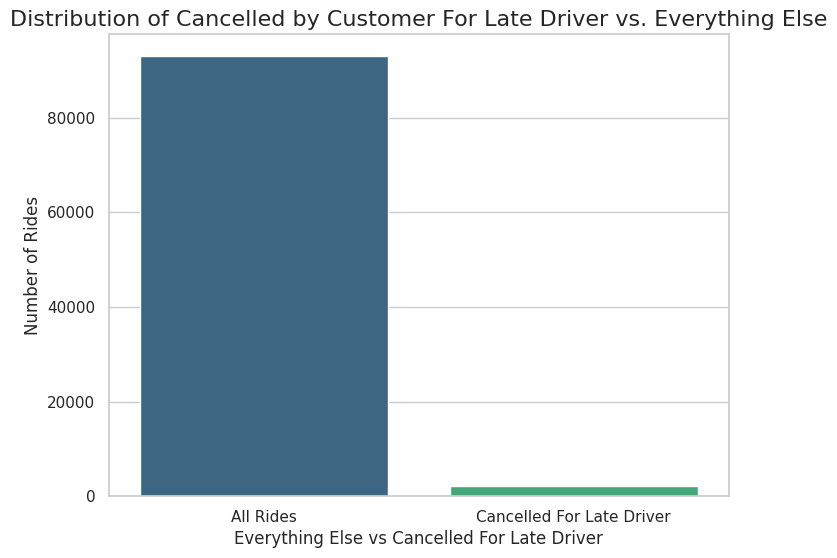

is_cancelled
0    0.976532
1    0.023468
Name: proportion, dtype: float64


<Figure size 800x600 with 0 Axes>

In [ ]:
# Checking imbalance
# Set the plot style
sns.set_style("whitegrid")

# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='is_cancelled', data=df1, palette="viridis")
plt.title('Distribution of Cancelled by Customer For Late Driver vs. Everything Else', fontsize=16)
plt.xticks([0, 1], ['All Rides', 'Cancelled For Late Driver'])
plt.ylabel('Number of Rides')
plt.xlabel('Everything Else vs Cancelled For Late Driver')
plt.show()


plt.figure(figsize=(8, 6)) # Set a good figure size
sns.set_theme(style="whitegrid") # Apply a nice theme

print(df1['is_cancelled'].value_counts(normalize=True))

In [ ]:
df1.head(1)

,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Booking Value,Ride Distance,booking_timestamp,hour,day,month,day_of_month,is_cancelled,driver_ratings,customer_ratings,customer_patience,historical_customer_avg_rating,historical_customer_rating_binned
148537,Go Sedan,Mandi House,Ghitorni,6.2,458.0,13.32,2024-09-26 12:58:18,12,Thursday,9,26,0,Good,Good,new_customer,NaN,No Prior Rating


In [ ]:
df1 = df1.rename(columns={
    'Vehicle Type': 'vehicle_type',
    'Pickup Location': 'pickup_location',
    'Drop Location': 'drop_location',
    'Avg VTAT': 'vehicle_arrival_time',
    'Booking Value': 'ride_cost',
    'Ride Distance': 'distance',
    })

In [ ]:
df1.head()

,vehicle_type,pickup_location,drop_location,vehicle_arrival_time,ride_cost,distance,booking_timestamp,hour,day,month,day_of_month,is_cancelled,driver_ratings,customer_ratings,customer_patience,historical_customer_avg_rating,historical_customer_rating_binned
148537,Go Sedan,Mandi House,Ghitorni,6.2,458.0,13.32,2024-09-26 12:58:18,12,Thursday,9,26,0,Good,Good,new_customer,NaN,No Prior Rating
43914,Bike,Delhi Gate,Ashram,13.9,1498.0,20.26,2024-03-22 10:10:36,10,Friday,3,22,0,Good,Good,new_customer,NaN,No Prior Rating
147050,Auto,IMT Manesar,Arjangarh,2.0,448.0,12.93,2024-03-02 11:44:26,11,Saturday,3,2,0,Good,Good,new_customer,NaN,No Prior Rating
133855,eBike,Mundka,Vaishali,6.2,419.0,36.14,2024-02-11 10:14:40,10,Sunday,2,11,0,Good,Good,new_customer,NaN,No Prior Rating
52478,Premier Sedan,DLF City Court,Hauz Rani,6.8,253.0,37.10,2024-12-12 20:27:00,20,Thursday,12,12,0,Good,Good,new_customer,NaN,No Prior Rating


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95235 entries, 148537 to 97229
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   vehicle_type                       95235 non-null  object        
 1   pickup_location                    95235 non-null  object        
 2   drop_location                      95235 non-null  object        
 3   vehicle_arrival_time               95235 non-null  float64       
 4   ride_cost                          95235 non-null  float64       
 5   distance                           95235 non-null  float64       
 6   booking_timestamp                  95235 non-null  datetime64[ns]
 7   hour                               95235 non-null  int32         
 8   day                                95235 non-null  object        
 9   month                              95235 non-null  int32         
 10  day_of_month                      

In [ ]:
output_filename = './Dataset/post_clean.csv'
df1.to_csv(output_filename, index=False)

In [ ]:
import pandas as pd
import numpy as np
import requests

def fetch_and_merge_weather(df1):
    """
    Fetches historical weather data from Open-Meteo and merges it
    into the main ride DataFrame (df1).

    This function assumes 'df1' is your DataFrame and has a
    'booking_timestamp' column.
    """
    print("--- 1. Starting Weather Data Fetch & Merge ---")

    # --- Step 1: Ensure 'booking_timestamp' is a datetime and sorted ---
    # We must sort by time to perform the merge_asof
    if not pd.api.types.is_datetime64_any_dtype(df1['booking_timestamp']):
        df1['booking_timestamp'] = pd.to_datetime(df1['booking_timestamp'])
        print("Converted 'booking_timestamp' to datetime.")

    df1 = df1.sort_values('booking_timestamp')
    print("DataFrame sorted by 'booking_timestamp'.")

    # --- Step 2: Find the date range for the API call ---
    start_date = df1['booking_timestamp'].min().strftime('%Y-%m-%d')
    end_date = df1['booking_timestamp'].max().strftime('%Y-%m-%d')
    print(f"Fetching weather data from {start_date} to {end_date}...")

    # --- Step 3: Define API parameters for New Delhi ---
    # Coordinates for New Delhi (Safdarjung)
    LATITUDE = 28.58
    LONGITUDE = 77.21

    # Define the weather features we want (hourly)
    # We get temperature, humidity, precipitation (rain), and the WMO weather code
    api_url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={LATITUDE}&longitude={LONGITUDE}&"
        f"start_date={start_date}&end_date={end_date}&"
        f"hourly=temperature_2m,relative_humidity_2m,precipitation,weather_code&"
        f"timezone=Asia/Kolkata"
    )

    # --- Step 4: Call the API and process the data ---
    try:
        response = requests.get(api_url)
        response.raise_for_status() # Raises an error if the request failed
        weather_data_json = response.json()
    except requests.exceptions.RequestException as e:
        print(f"ERROR: Failed to fetch data from Open-Meteo API. {e}")
        return df1 # Return the original dataframe

    if 'hourly' not in weather_data_json:
        print("ERROR: 'hourly' data not found in API response.")
        return df1

    # Convert the 'hourly' data into a pandas DataFrame
    weather_df = pd.DataFrame(weather_data_json['hourly'])

    # Convert 'time' to datetime and rename columns for clarity
    weather_df['time'] = pd.to_datetime(weather_df['time'])
    weather_df = weather_df.rename(columns={
        'time': 'weather_timestamp',
        'temperature_2m': 'temperature',
        'relative_humidity_2m': 'humidity',
        'precipitation': 'precipitation_mm'
    })

    # Ensure weather_df is sorted by time
    weather_df = weather_df.sort_values('weather_timestamp')
    print("Successfully fetched and processed weather data.")

    # --- Step 5: Map Weather Codes to Categories ---
    # This function groups the 100 WMO codes into simple, useful categories
    def map_weather_code(code):
        if code == 0:
            return 'Clear'
        if code in [1, 2, 3]:
            return 'Mainly Clear/Cloudy'
        if code in [45, 48]:
            return 'Fog'
        if code in [51, 53, 55, 56, 57]:
            return 'Drizzle'
        if code in [61, 63, 65, 66, 67]:
            return 'Rain'
        if code in [80, 81, 82]:
            return 'Rain Showers'
        if code in [71, 73, 75, 77]:
            return 'Snow'
        if code in [95, 96, 99]:
            return 'Thunderstorm'
        return 'Other'

    weather_df['weather_condition'] = weather_df['weather_code'].apply(map_weather_code)
    weather_df = weather_df.drop(columns=['weather_code']) # We only need the category
    print("Mapped weather codes to categories.")

    # --- Step 6: Merge the DataFrames using pd.merge_asof ---
    # This is the most important step.
    # It matches each ride to the *last known* hourly weather report.
    # e.g., A 12:58 ride gets the 12:00 weather.
    df_merged = pd.merge_asof(
        df1,
        weather_df,
        left_on='booking_timestamp',
        right_on='weather_timestamp',
        direction='backward' # Finds the most recent weather *before* the ride
    )

    print("--- 2. Weather data successfully merged! ---")
    return df_merged

# --- HOW TO USE THIS SCRIPT ---
#
# 1. Make sure 'df' (your DataFrame from 'post_clean_1.csv') is loaded.
# 2. Call the function and pass your DataFrame to it.
#


In [ ]:

#     # This assumes 'df' is already loaded in your environment
df_with_weather = fetch_and_merge_weather(df1)

# 3. Check the new columns
print("\n--- Final DataFrame Head with Weather ---")
print(df_with_weather[['booking_timestamp', 'weather_timestamp', 'temperature', 'precipitation_mm', 'weather_condition']].head())

print("\n--- New Weather Feature Value Counts ---")

--- 1. Starting Weather Data Fetch & Merge ---
DataFrame sorted by 'booking_timestamp'.
Fetching weather data from 2024-01-01 to 2024-12-30...
Successfully fetched and processed weather data.
Mapped weather codes to categories.
--- 2. Weather data successfully merged! ---

--- Final DataFrame Head with Weather ---
    booking_timestamp   weather_timestamp  temperature  precipitation_mm  \
0 2024-01-01 00:19:34 2024-01-01 00:00:00          7.1               0.0   
1 2024-01-01 01:35:18 2024-01-01 01:00:00          6.9               0.0   
2 2024-01-01 01:53:01 2024-01-01 01:00:00          6.9               0.0   
3 2024-01-01 03:59:29 2024-01-01 03:00:00          6.0               0.0   
4 2024-01-01 04:00:07 2024-01-01 04:00:00          6.5               0.0   

     weather_condition  
0                Clear  
1                Clear  
2                Clear  
3  Mainly Clear/Cloudy  
4  Mainly Clear/Cloudy  

--- New Weather Feature Value Counts ---


In [ ]:

print(df_with_weather['weather_condition'].value_counts())


weather_condition
Clear                  54566
Mainly Clear/Cloudy    30335
Drizzle                 8242
Rain                    2092
Name: count, dtype: int64


In [ ]:

df1 = df_with_weather.copy()

In [ ]:
df1['pickup_location'].nunique()

176

In [ ]:
df1['drop_location'].nunique()

176

In [ ]:
df1.describe()

,vehicle_arrival_time,ride_cost,distance,booking_timestamp,hour,month,day_of_month,is_cancelled,historical_customer_avg_rating,weather_timestamp,temperature,humidity,precipitation_mm
count,95235.000000,95235.000000,95235.000000,95235,95235.000000,95235.000000,95235.000000,95235.000000,467.000000,95235,95235.000000,95235.000000,95235.000000
mean,8.607074,508.247681,25.997255,2024-07-01 07:18:28.273082368,14.030209,6.490859,15.652449,0.023468,4.389936,2024-07-01 06:48:32.093242880,26.299089,56.134331,0.121586
min,2.000000,50.000000,2.000000,2024-01-01 00:19:34,0.000000,1.000000,1.000000,0.000000,3.000000,2024-01-01 00:00:00,4.000000,5.000000,0.000000
25%,5.300000,237.000000,14.260000,2024-03-31 22:08:22.500000,10.000000,3.000000,8.000000,0.000000,4.200000,2024-03-31 21:30:00,20.300000,34.000000,0.000000
50%,8.600000,416.000000,26.010000,2024-06-30 20:16:46,15.000000,6.000000,16.000000,0.000000,4.400000,2024-06-30 20:00:00,27.400000,59.000000,0.000000
75%,11.800000,686.000000,37.780000,2024-09-30 20:31:54.500000,18.000000,9.000000,23.000000,0.000000,4.700000,2024-09-30 20:00:00,31.800000,78.000000,0.000000
max,20.000000,4277.000000,50.000000,2024-12-30 23:21:12,23.000000,12.000000,31.000000,1.000000,5.000000,2024-12-30 23:00:00,46.100000,100.000000,30.400000
std,3.814253,393.307010,13.733142,NaN,5.423418,3.444932,8.788307,0.151386,0.445778,NaN,8.431816,25.691136,0.883676


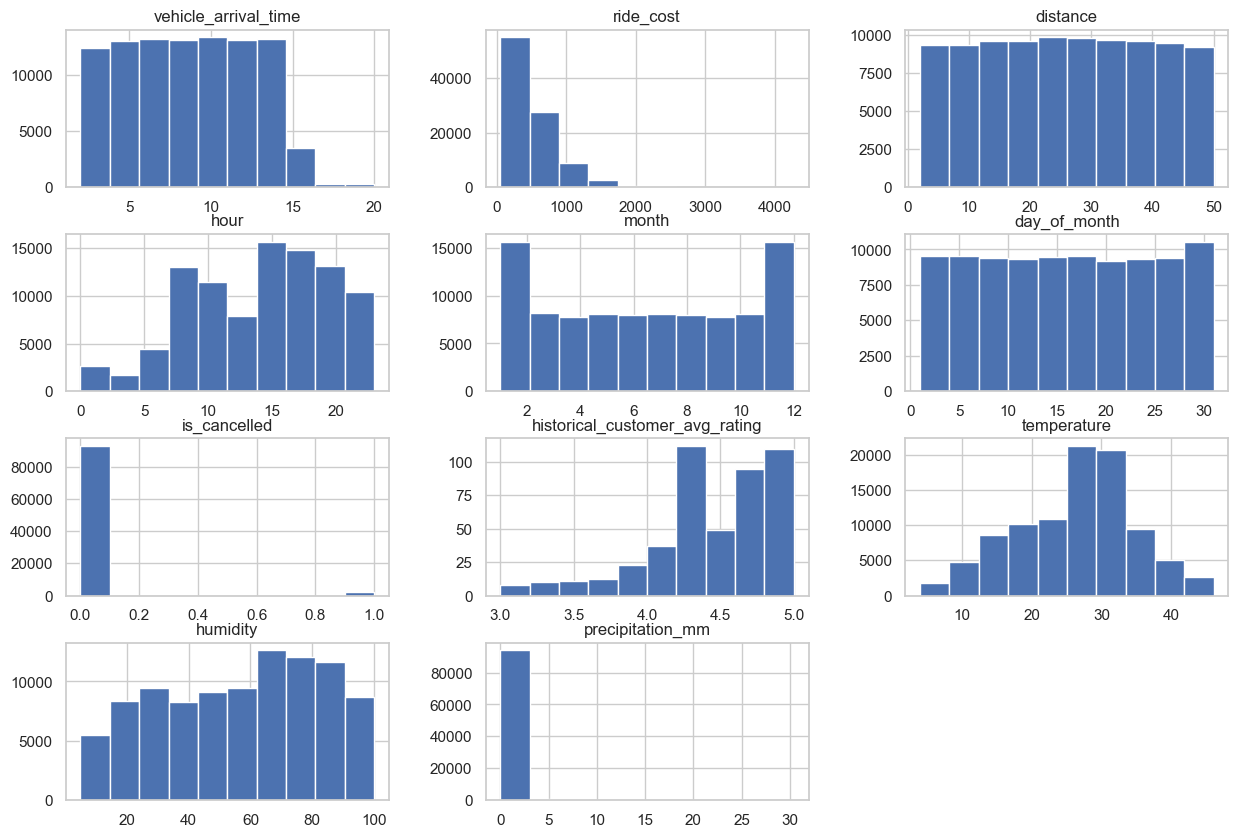

In [ ]:
df1[['vehicle_arrival_time', 'ride_cost', 'distance', 'hour', 'day', 'month', 'day_of_month', 'is_cancelled',
     'historical_customer_avg_rating','temperature', 'humidity', 'precipitation_mm']].hist(figsize=(15, 10))
plt.show()

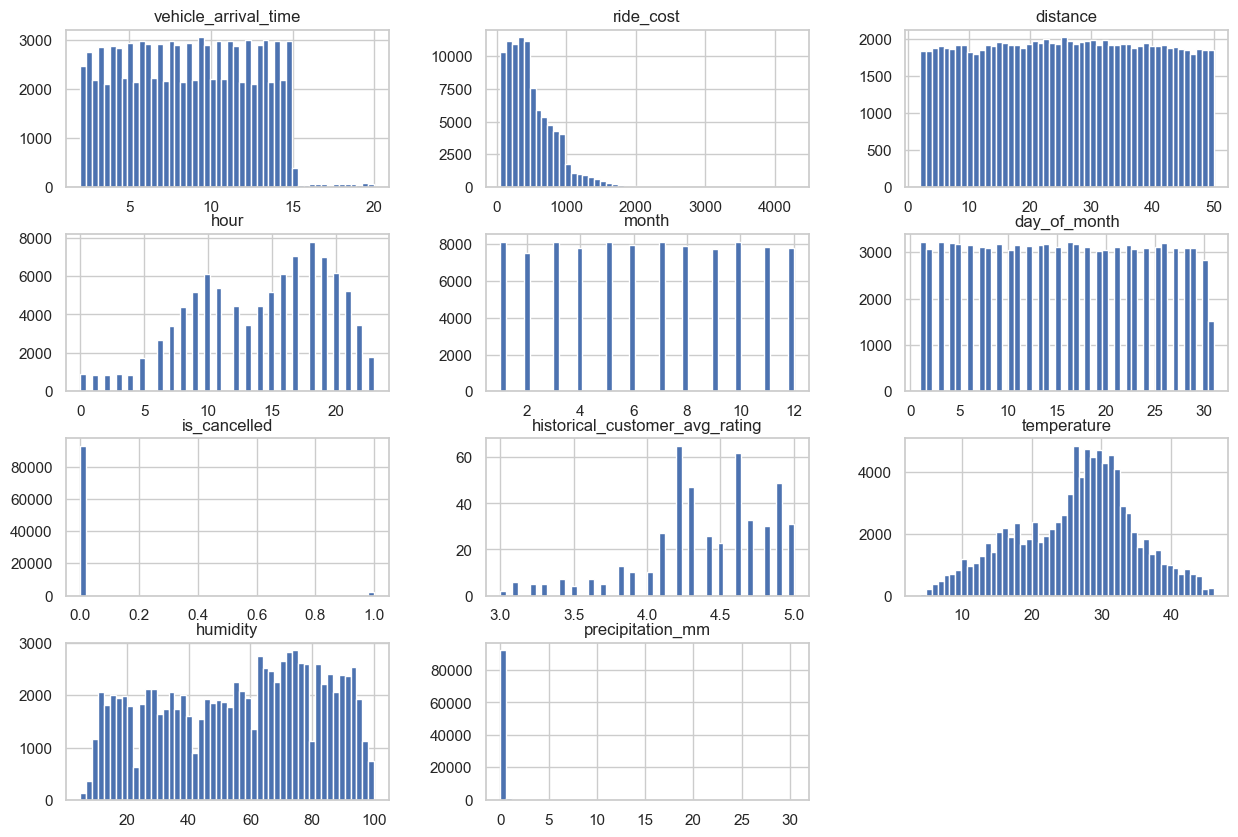

In [ ]:
df1[['vehicle_arrival_time', 'ride_cost', 'distance', 'hour', 'day', 'month', 'day_of_month', 'is_cancelled',
     'historical_customer_avg_rating','temperature', 'humidity', 'precipitation_mm']].hist(bins = 50,figsize=(15, 10))
plt.show()

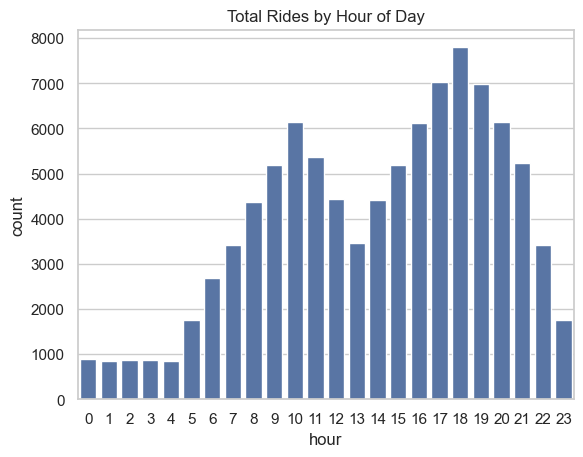

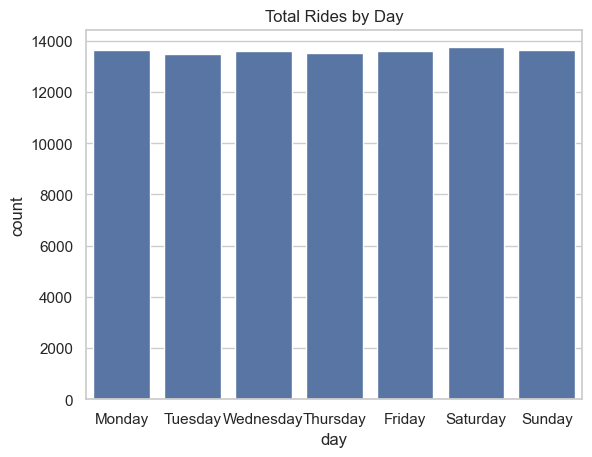

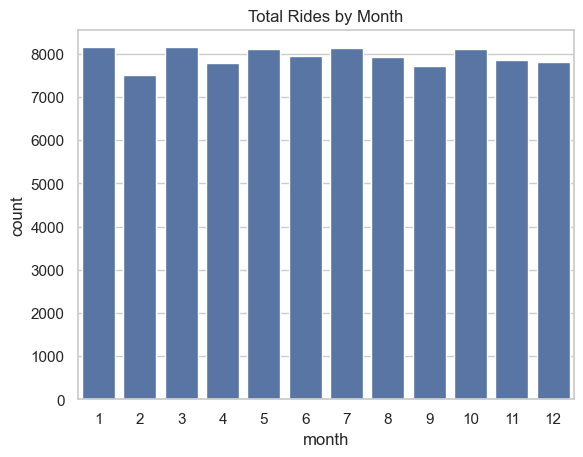

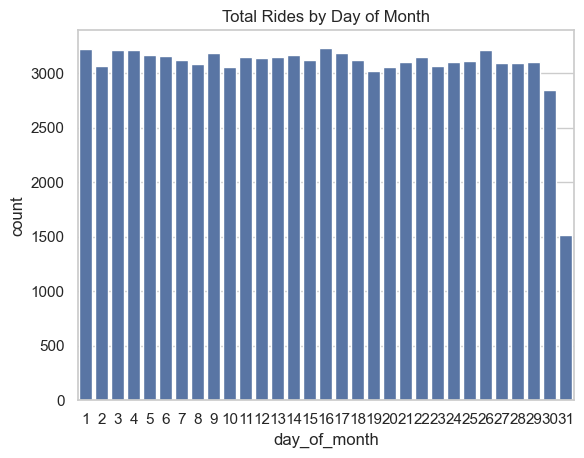

In [ ]:
# Plot bar charts (countplots) for time
import seaborn as sns

sns.countplot(data=df1, x='hour')
plt.title('Total Rides by Hour of Day')
plt.show()

sns.countplot(data=df1, x='day')
plt.title('Total Rides by Day')
plt.show()

sns.countplot(data=df1, x='month')
plt.title('Total Rides by Month')
plt.show()

sns.countplot(data=df1, x='day_of_month')
plt.title('Total Rides by Day of Month')
plt.show()

In [ ]:
import numpy as np

# --- 1. Define Conditions (Keywords) for Pickup Location ---
# We create a list of conditions based on keywords for each zone
# The order matters; it will pick the first one that matches.

pickup_conditions = [
    # --- Gurgaon (NCR) ---
    df1['pickup_location'].str.contains('Gurgaon|Manesar|DLF|Palam Vihar|Ambience Mall|Ardee City|Badshahpur|Basai Dhankot|Cyber Hub|Golf Course Road|Hero Honda Chowk|Huda City Centre|IFFCO Chowk|Kadarpur|Khandsa|Kherki Daula Toll|MG Road|Narsinghpur|New Colony|Pataudi Chowk|Rajiv Nagar|Sikanderpur|Sohna Road|Subhash Chowk|Sushant Lok|Udyog Vihar|Udyog Vihar Phase 4|Vatika Chowk|Gwal Pahari', case=False, na=False),

    # --- Noida (NCR) ---
    df1['pickup_location'].str.contains('Noida|Sector|Botanical Garden', case=False, na=False),

    # --- Ghaziabad (NCR) ---
    df1['pickup_location'].str.contains('Ghaziabad|Vaishali|Indirapuram|Kaushambi|Raj Nagar Extension', case=False, na=False),

    # --- Faridabad (NCR) ---
    df1['pickup_location'].str.contains('Faridabad', case=False, na=False),

    # --- Outer NCR (New Category) ---
    df1['pickup_location'].str.contains('Bhiwadi|Meerut|Panipat', case=False, na=False), # <- NEW

    # --- Delhi Zones ---
    df1['pickup_location'].str.contains('Airport|T1|T3|Aerocity', case=False, na=False),
    df1['pickup_location'].str.contains('Hauz Khas|Saket|Vasant Kunj|Ghitorni|Mehrauli|Arjangarh|Hauz Rani|Ashram|South Ex|AIIMS|Aya Nagar|Bhikaji Cama Place|Chhatarpur|Chirag Delhi|Govindpuri|Green Park|IGNOU Road|IIT Delhi|INA Market|Jasola|Jor Bagh|Lok Kalyan Marg|Maidan Garhi|Malviya Nagar|Moolchand|Munirka|Panchsheel Park|Qutub Minar|RK Puram|Saidulajab|Sarojini Nagar|Sultanpur|Tughlakabad|Udyog Bhawan|Vinobapuri|Badarpur', case=False, na=False),
    df1['pickup_location'].str.contains('Mandi House|Connaught|CP|Paharganj|Karol Bagh|Delhi Gate|Central Secretariat|Barakhamba Road|Chanakyapuri|Chandni Chowk|India Gate|ITO|Jama Masjid|Khan Market|Lal Quila|New Delhi Railway Station|Patel Chowk|Pragati Maidan|Rajiv Chowk|Tis Hazari', case=False, na=False),
    df1['pickup_location'].str.contains('Jhilmil|Preet Vihar|Mayur Vihar|Patparganj|Laxmi Nagar|Akshardham|Anand Vihar|Anand Vihar ISBT|Dilshad Garden|Karkarduma|Mansarovar Park|Nirman Vihar|Seelampur|Shahdara|Shastri Park|Welcome|Yamuna Bank', case=False, na=False),
    df1['pickup_location'].str.contains('Dwarka|Janakpuri|Mundka|Najafgarh|Tilak Nagar|Vikaspuri|Ashok Park Main|Inderlok|Kanhaiya Nagar|Kirti Nagar|Madipur|Moti Nagar|Nawada|Paschim Vihar|Peeragarhi|Punjabi Bagh|Rajouri Garden|Ramesh Nagar|Satguru Ram Singh Marg|Shastri Nagar|Shivaji Park|Subhash Nagar|Tagore Garden|Uttam Nagar', case=False, na=False),
    df1['pickup_location'].str.contains('Rohini|Civil Lines|Pitampura|Model Town|Adarsh Nagar|Ashok Vihar|Azadpur|GTB Nagar|Indraprastha|Jahangirpuri|Kashmere Gate|Kashmere Gate ISBT|Keshav Puram|Netaji Subhash Place|Pulbangash|Rithala|Samaypur Badli|Vidhan Sabha|Vishwavidyalaya', case=False, na=False)
]

# --- 2. Define Choices (Zone Names) ---
# These are the zone names that correspond to the conditions above
choices = [
    'Gurgaon',
    'Noida',
    'Ghaziabad',
    'Faridabad',
    'Outer NCR', # <- NEW
    'Airport Area',
    'South Delhi',
    'Central Delhi',
    'East Delhi',
    'West Delhi',
    'North Delhi'
]

# --- 3. Apply to 'pickup_location' ---
# The 'default' is what we assign if no keywords are met
df1['pickup_zone'] = np.select(pickup_conditions, choices, default='Other (Delhi)')

# --- 4. Define Conditions for Drop Location ---
# We must do the same thing for the 'drop_location' column
drop_conditions = [
    # --- Gurgaon (NCR) ---
    df1['drop_location'].str.contains('Gurgaon|Manesar|DLF|Palam Vihar|Ambience Mall|Ardee City|Badshahpur|Basai Dhankot|Cyber Hub|Golf Course Road|Hero Honda Chowk|Huda City Centre|IFFCO Chowk|Kadarpur|Khandsa|Kherki Daula Toll|MG Road|Narsinghpur|New Colony|Pataudi Chowk|Rajiv Nagar|Sikanderpur|Sohna Road|Subhash Chowk|Sushant Lok|Udyog Vihar|Udyog Vihar Phase 4|Vatika Chowk|Gwal Pahari', case=False, na=False),

    # --- Noida (NCR) ---
    df1['drop_location'].str.contains('Noida|Sector|Botanical Garden', case=False, na=False),

    # --- Ghaziabad (NCR) ---
    df1['drop_location'].str.contains('Ghaziabad|Vaishali|Indirapuram|Kaushambi|Raj Nagar Extension', case=False, na=False),

    # --- Faridabad (NCR) ---
    df1['drop_location'].str.contains('Faridabad', case=False, na=False),

    # --- Outer NCR (New Category) ---
    df1['drop_location'].str.contains('Bhiwadi|Meerut|Panipat', case=False, na=False), # <- NEW

    # --- Delhi Zones ---
    df1['drop_location'].str.contains('Airport|T1|T3|Aerocity', case=False, na=False),
    df1['drop_location'].str.contains('Hauz Khas|Saket|Vasant Kunj|Ghitorni|Mehrauli|Arjangarh|Hauz Rani|Ashram|South Ex|AIIMS|Aya Nagar|Bhikaji Cama Place|Chhatarpur|Chirag Delhi|Govindpuri|Green Park|IGNOU Road|IIT Delhi|INA Market|Jasola|Jor Bagh|Lok Kalyan Marg|Maidan Garhi|Malviya Nagar|Moolchand|Munirka|Panchsheel Park|Qutub Minar|RK Puram|Saidulajab|Sarojini Nagar|Sultanpur|Tughlakabad|Udyog Bhawan|Vinobapuri|Badarpur', case=False, na=False),
    df1['drop_location'].str.contains('Mandi House|Connaught|CP|Paharganj|Karol Bagh|Delhi Gate|Central Secretariat|Barakhamba Road|Chanakyapuri|Chandni Chowk|India Gate|ITO|Jama Masjid|Khan Market|Lal Quila|New Delhi Railway Station|Patel Chowk|Pragati Maidan|Rajiv Chowk|Tis Hazari', case=False, na=False),
    df1['drop_location'].str.contains('Jhilmil|Preet Vihar|Mayur Vihar|Patparganj|Laxmi Nagar|Akshardham|Anand Vihar|Anand Vihar ISBT|Dilshad Garden|Karkarduma|Mansarovar Park|Nirman Vihar|Seelampur|Shahdara|Shastri Park|Welcome|Yamuna Bank', case=False, na=False),
    df1['drop_location'].str.contains('Dwarka|Janakpuri|Mundka|Najafgarh|Tilak Nagar|Vikaspuri|Ashok Park Main|Inderlok|Kanhaiya Nagar|Kirti Nagar|Madipur|Moti Nagar|Nawada|Paschim Vihar|Peeragarhi|Punjabi Bagh|Rajouri Garden|Ramesh Nagar|Satguru Ram Singh Marg|Shastri Nagar|Shivaji Park|Subhash Nagar|Tagore Garden|Uttam Nagar', case=False, na=False),
    df1['drop_location'].str.contains('Rohini|Civil Lines|Pitampura|Model Town|Adarsh Nagar|Ashok Vihar|Azadpur|GTB Nagar|Indraprastha|Jahangirpuri|Kashmere Gate|Kashmere Gate ISBT|Keshav Puram|Netaji Subhash Place|Pulbangash|Rithala|Samaypur Badli|Vidhan Sabha|Vishwavidyalaya', case=False, na=False)
]

# --- 5. Apply to 'drop_location' ---
df1['drop_zone'] = np.select(drop_conditions, choices, default='Other (Delhi)')

# --- 6. (IMPORTANT) Check Your Work ---
print("--- Pickup Zone Distribution ---")
print(df1['pickup_zone'].value_counts())
print("\n" + "="*40 + "\n")

print("--- Drop Zone Distribution ---")
print(df1['drop_zone'].value_counts())
print("\n" + "="*40 + "\n")

# --- 7. Check the 'Other' Category ---
# This helps you find locations you might have missed
print("--- Unmapped Pickup Locations (Category 'Other') ---")
print(df1[df1['pickup_zone'] == 'Other (Delhi)']['pickup_location'].value_counts().head(200))

--- Pickup Zone Distribution ---
pickup_zone
South Delhi      20530
Gurgaon          19520
West Delhi       12104
North Delhi      10807
Central Delhi    10283
East Delhi        8504
Noida             4315
Other (Delhi)     4307
Ghaziabad         2685
Outer NCR         1601
Airport Area       579
Name: count, dtype: int64


--- Drop Zone Distribution ---
drop_zone
South Delhi      20444
Gurgaon          19326
West Delhi       11964
North Delhi      10900
Central Delhi    10222
East Delhi        8722
Noida             4444
Other (Delhi)     4415
Ghaziabad         2702
Outer NCR         1586
Airport Area       510
Name: count, dtype: int64


--- Unmapped Pickup Locations (Category 'Other') ---
pickup_location
Greater Kailash    574
Sarai Kale Khan    545
Sonipat            545
Nehru Place        543
Okhla              539
Lajpat Nagar       523
Kalkaji            519
Bahadurgarh        519
Name: count, dtype: int64


In [ ]:
# --- 1. First, make sure you have run your np.select code ---
# (This ensures the 'pickup_zone' and 'drop_zone' columns exist)


# --- 2. Get the unique unclassified pickup locations ---
unclassified_pickups = df1[df1['pickup_zone'] == 'Other (Delhi)']['pickup_location'].unique()

# --- 3. Get the unique unclassified drop locations ---
unclassified_drops = df1[df1['drop_zone'] == 'Other (Delhi)']['drop_location'].unique()

# --- 4. Combine them into one, final, unique list ---
# We use np.union1d to get a single, sorted, unique array of all
# unclassified locations from both columns.
all_unclassified = np.union1d(unclassified_pickups, unclassified_drops)

# --- 5. Print the full list ---
# This is the array you should copy and paste back to me.
print("--- ALL UNCLASSIFIED LOCATIONS (Please copy this list) ---")
print(all_unclassified)

--- ALL UNCLASSIFIED LOCATIONS (Please copy this list) ---
['Bahadurgarh' 'Greater Kailash' 'Kalkaji' 'Lajpat Nagar' 'Nehru Place'
 'Okhla' 'Sarai Kale Khan' 'Sonipat']


In [ ]:
print(df1.shape)
df1.head()

(95235, 24)


,vehicle_type,pickup_location,drop_location,vehicle_arrival_time,ride_cost,distance,booking_timestamp,hour,day,month,day_of_month,is_cancelled,driver_ratings,customer_ratings,customer_patience,historical_customer_avg_rating,historical_customer_rating_binned,weather_timestamp,temperature,humidity,precipitation_mm,weather_condition,pickup_zone,drop_zone
0,Bike,Udyog Vihar,Ambience Mall,10.8,99.0,37.98,2024-01-01 00:19:34,0,Monday,1,1,0,Good,Good,new_customer,NaN,No Prior Rating,2024-01-01 00:00:00,7.1,99,0.0,Clear,Gurgaon,Gurgaon
1,Go Mini,Basai Dhankot,Madipur,8.5,114.0,39.29,2024-01-01 01:35:18,1,Monday,1,1,0,Good,Good,new_customer,NaN,No Prior Rating,2024-01-01 01:00:00,6.9,100,0.0,Clear,Gurgaon,West Delhi
2,Go Mini,Jhilmil,Welcome,8.1,735.0,39.39,2024-01-01 01:53:01,1,Monday,1,1,0,Good,Good,new_customer,NaN,No Prior Rating,2024-01-01 01:00:00,6.9,100,0.0,Clear,East Delhi,East Delhi
3,Go Mini,Sarojini Nagar,Madipur,2.9,918.0,44.21,2024-01-01 03:59:29,3,Monday,1,1,0,Good,Good,new_customer,NaN,No Prior Rating,2024-01-01 03:00:00,6.0,100,0.0,Mainly Clear/Cloudy,South Delhi,West Delhi
4,eBike,Panchsheel Park,Pragati Maidan,8.6,423.0,40.82,2024-01-01 04:00:07,4,Monday,1,1,0,Good,Good,new_customer,NaN,No Prior Rating,2024-01-01 04:00:00,6.5,99,0.0,Mainly Clear/Cloudy,South Delhi,Central Delhi


In [ ]:
output_filename = './Dataset/post_clean_1.csv'
df1.to_csv(output_filename, index=False)

In [ ]:
X = df1.copy()
drop_columns = ['pickup_location', 'drop_location','customer_ratings', 'driver_ratings','weather_timestamp']
X = X.drop(drop_columns, axis=1)

In [ ]:
X = pd.get_dummies(X, columns=['vehicle_type', 'day', 'historical_customer_avg_rating',	'historical_customer_rating_binned', 'customer_patience', 'pickup_zone', 'drop_zone', 'weather_condition'], drop_first=True)
print(X.shape)

(95235, 74)


In [ ]:
X.head()

,vehicle_arrival_time,ride_cost,distance,booking_timestamp,hour,month,day_of_month,is_cancelled,temperature,humidity,precipitation_mm,vehicle_type_Bike,vehicle_type_Go Mini,vehicle_type_Go Sedan,vehicle_type_Premier Sedan,vehicle_type_Uber XL,vehicle_type_eBike,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,historical_customer_avg_rating_3.1,historical_customer_avg_rating_3.2,historical_customer_avg_rating_3.3,historical_customer_avg_rating_3.4,historical_customer_avg_rating_3.5,historical_customer_avg_rating_3.6,historical_customer_avg_rating_3.7,historical_customer_avg_rating_3.8,historical_customer_avg_rating_3.9,historical_customer_avg_rating_4.0,historical_customer_avg_rating_4.1,historical_customer_avg_rating_4.2,historical_customer_avg_rating_4.3,historical_customer_avg_rating_4.4,historical_customer_avg_rating_4.5,historical_customer_avg_rating_4.6,historical_customer_avg_rating_4.699999999999999,historical_customer_avg_rating_4.7,historical_customer_avg_rating_4.8,historical_customer_avg_rating_4.9,historical_customer_avg_rating_5.0,historical_customer_rating_binned_Historically Good,historical_customer_rating_binned_No Prior Rating,customer_patience_patient,customer_patience_very patient,customer_patience_extremely patient,customer_patience_new_customer,customer_patience_no_cancel_history,pickup_zone_Central Delhi,pickup_zone_East Delhi,pickup_zone_Ghaziabad,pickup_zone_Gurgaon,pickup_zone_Noida,pickup_zone_North Delhi,pickup_zone_Other (Delhi),pickup_zone_Outer NCR,pickup_zone_South Delhi,pickup_zone_West Delhi,drop_zone_Central Delhi,drop_zone_East Delhi,drop_zone_Ghaziabad,drop_zone_Gurgaon,drop_zone_Noida,drop_zone_North Delhi,drop_zone_Other (Delhi),drop_zone_Outer NCR,drop_zone_South Delhi,drop_zone_West Delhi,weather_condition_Drizzle,weather_condition_Mainly Clear/Cloudy,weather_condition_Rain
0,10.8,99.0,37.98,2024-01-01 00:19:34,0,1,1,0,7.1,99,0.0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,8.5,114.0,39.29,2024-01-01 01:35:18,1,1,1,0,6.9,100,0.0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2,8.1,735.0,39.39,2024-01-01 01:53:01,1,1,1,0,6.9,100,0.0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,2.9,918.0,44.21,2024-01-01 03:59:29,3,1,1,0,6.0,100,0.0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False
4,8.6,423.0,40.82,2024-01-01 04:00:07,4,1,1,0,6.5,99,0.0,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,F

In [ ]:
full_corr = X.corr()

# Find Top 15 Features Correlated with Target ---
y = 'is_cancelled' # <--- Change this if your target is named differently

# Get all correlations with the target, take absolute value, and sort
corr_with_target = full_corr[y].abs().sort_values(ascending=False)

# Select the Top Features ---
# The first item [0] will be the target itself (corr=1.0)
# So, we select [1:11] to get the 10 *other* features
top_15_features = corr_with_target[1:15].index

print(f"Top 15 features most correlated with '{y}':")
print(top_15_features.tolist())

Top 15 features most correlated with 'is_cancelled':
['vehicle_arrival_time', 'vehicle_type_Go Mini', 'customer_patience_extremely patient', 'vehicle_type_Bike', 'historical_customer_avg_rating_4.3', 'historical_customer_avg_rating_3.3', 'drop_zone_South Delhi', 'drop_zone_Other (Delhi)', 'historical_customer_avg_rating_4.6', 'customer_patience_very patient', 'pickup_zone_Noida', 'historical_customer_avg_rating_4.0', 'customer_patience_new_customer', 'weather_condition_Drizzle']


<Axes: >

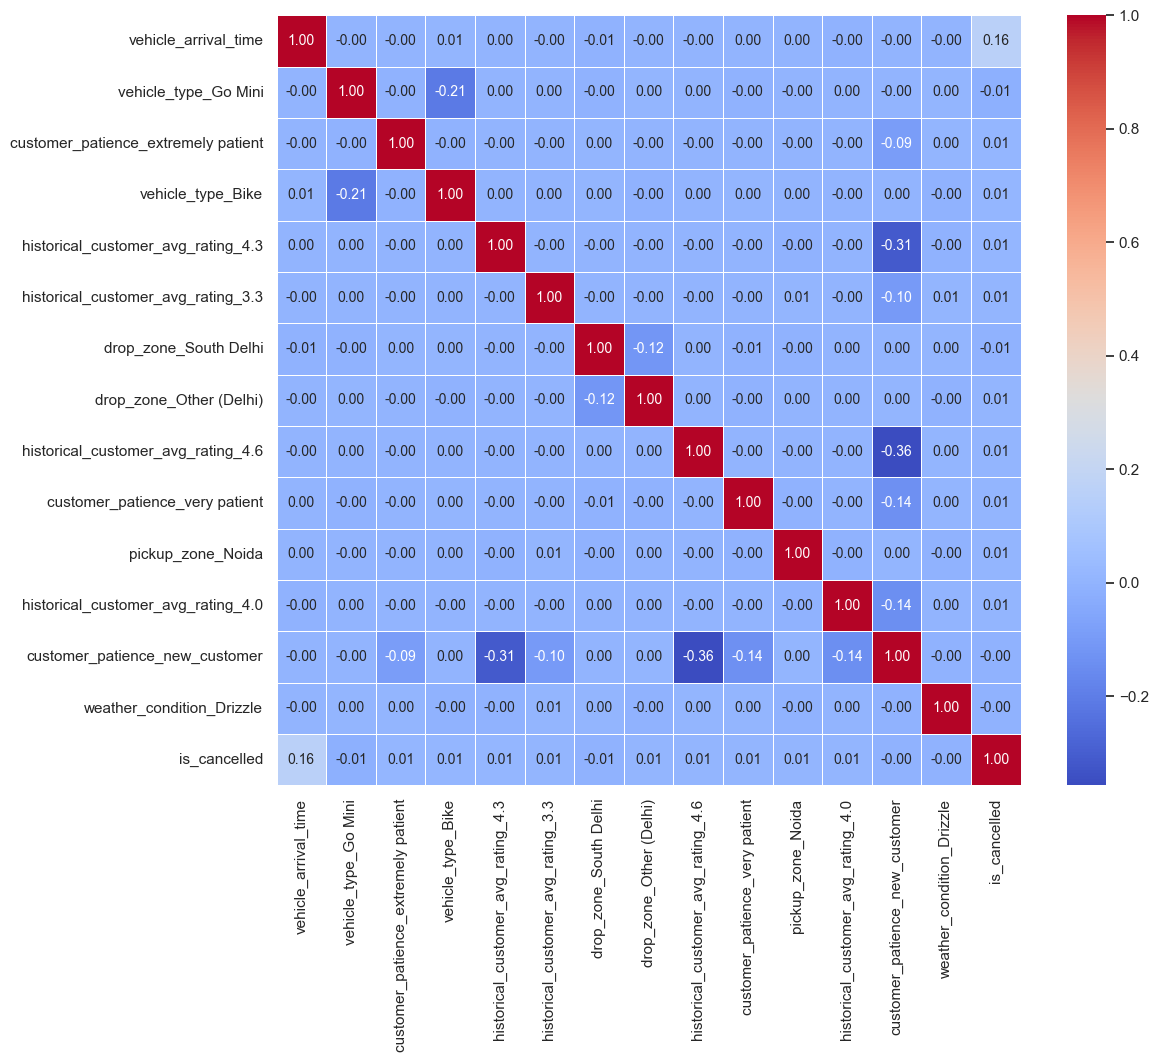

In [ ]:
top_features_list = top_15_features.tolist() + [y]
df_top_15 = X[top_features_list]

plt.figure(figsize=(12, 10)) # A 12x10 figure is good for 11 features
sns.heatmap(
    df_top_15.corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={"size": 10} # Make annotations readable
)